In [ ]:
# Get the data from the server. Run this only once
!curl http://grfia.dlsi.ua.es/homus/HOMUS.zip > HOMUS.zip

In [84]:
# Use this cell for shell commands, if necessary
!pip3 install matplotlib

    100% |████████████████████████████████| 11.2MB 115kB/s 
    100% |████████████████████████████████| 61kB 7.2MB/s 


In [1]:
%matplotlib inline
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.draw import line

In [2]:
BLK_COLOR = 0
WHT_COLOR = 255

In [3]:
def process_file(fileobj, exid):
    X = None
    y = None
    
    # The first line of the file is the note-type
    notetype = fileobj.readline()
    y = notetype.rstrip("\n")
#     print(y)

    # The rest of the lines are semi-colon separated point tuples, e.g. 5,6;1,5;8;9 etc.
    xstring = ""
    
    for line in fileobj:
        xstring += line.rstrip()
#     print(xstring)

    # Split the string based on the semicolon
    points_partition = xstring.strip(";").split(";")
    
    # Split the string based on the commas
    # The result is a doubly nested list, e.g. [['5','6'], ['1', '5'], ['8', '9'] ... ] etc
    points_split = [item.split(",") for item in points_partition]
    
    # Convert strings to ints. TODO: Make this a list comprehension instead of a for loop.
    for tup in points_split:
        tup[0] = int(tup[0])
        tup[1] = int(tup[1])


    # Create a DataFrame from the result
    df = pd.DataFrame(points_split, columns = ["x1", "x2"])
    df['id'] = exid
    df['y'] = y
    
    return df

In [31]:
INDIR = "../../HOMUS"

CAPCOUNT = float("inf") # <---- Change this to a set number for testing; to do everything set this high
capflag = False

# Each file will return a DataFrame; store these all in a list
allcoordslist = [] 

# this will be used as a progress indicator
count = 1;

for root, dirs, filenames in os.walk(INDIR):
    print("Working on " + str(count))
    count += 1
    
    for counter, f in enumerate(filenames):
        if counter > CAPCOUNT:
            capflag = True
            break
        else:
            fileobj = open(os.path.join(root, f), 'r')
            readresults = process_file(fileobj, f[:-4]) # Provide the filename (w/o '.txt') as a unique identifier
            fileobj.close()
            allcoordslist.append(readresults)
    if capflag:
        break

# Concatenate the list of DataFrames into one large dataframe. This is much, much, much, much more efficient
#     than doing this in the loop body.
allcoords = pd.concat(allcoordslist)

Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15
Working on 16
Working on 17
Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25
Working on 26
Working on 27
Working on 28
Working on 29
Working on 30
Working on 31
Working on 32
Working on 33
Working on 34
Working on 35
Working on 36
Working on 37
Working on 38
Working on 39
Working on 40
Working on 41
Working on 42
Working on 43
Working on 44
Working on 45
Working on 46
Working on 47
Working on 48
Working on 49
Working on 50
Working on 51
Working on 52
Working on 53
Working on 54
Working on 55
Working on 56
Working on 57
Working on 58
Working on 59
Working on 60
Working on 61
Working on 62
Working on 63
Working on 64
Working on 65
Working on 66
Working on 67
Working on 68
Working on 69
Working on 70
Working on 71
Working on 72
W

In [8]:
# Save the DataFrame to a CSV, just in case something terrible happens.

# If the notebook is in a git repository, DON'T RUN THIS!

allcoords.to_csv("../../homus_all.csv")

In [11]:
allcoords = pd.read_csv('../../homus_all.csv',index_col=0)

In [5]:
def round_to(x, nearest = 50):
    return int(nearest * round(float(x)/nearest))

# Get the dimension of the image based on the max of the tuples. Note that some files have negative coordinates, so 
x1_dim = round_to(max(allcoords['x1']) + abs(min(allcoords['x1'])), 25)
x2_dim = round_to(max(allcoords['x2']) + abs(min(allcoords['x2'])), 25)
xdims = [x1_dim, x2_dim]
# Add the negative offsets
# Note coordinate index starts at 0
allcoords['x1f'] = allcoords['x1'] + abs(min(allcoords['x1'])) 
allcoords['x2f'] = allcoords['x2'] + abs(min(allcoords['x2']))

In [6]:
def multiassignmentlist(ndarray_in, indexlist, value = 1):
    for l in indexlist:
        ndarray_in[(l[0],l[1])] = value
    return ndarray_in

In [37]:
def gen_feature_matrix(df_in, uniqueid, dims, idfieldname = 'id', keylist = ['x1f','x2f'], interpolate = False):
    for key in keylist:
        if key not in df_in.keys():
            raise KeyError("Could not find column name '" + str(key) + "' in input DataFrame")
            
    if uniqueid not in df_in[idfieldname].unique():
        raise KeyError(str(uniqueid) + " is not a member of column '" + str(idfieldname) +"'")
        
    if idfieldname not in df_in.keys():
        raise KeyError("Could not find column name '" + str(idfieldname) + "' in input DataFrame")
        
    dfsubset = df_in[df_in[idfieldname] == uniqueid]
    x1 = dfsubset[keylist[0]]
    x2 = dfsubset[keylist[1]]
    indexlist = [[x2[j], x1[j]] for j in range(0,len(x1))]
    outputX = np.ones((dims[0], dims[1])) * WHT_COLOR
    print(indexlist[1:5])
    if interpolate:
        for k in range(0,len(indexlist) - 2):
            pt1 = indexlist[k]
            pt2 = indexlist[k+1]
            rr, cc = line(pt1[0], pt1[1], pt2[0], pt2[1])
            
            outputX[rr,cc] = BLK_COLOR
    else:        
        outputX = multiassignmentlist(outputX, indexlist, BLK_COLOR)
    return outputX

In [39]:
def plot_image(uniqueid, coords, xdims, dfkeys = ['id','y'], interpolate = False):
    f = gen_feature_matrix(coords, uniqueid, xdims, interpolate = interpolate)
    dfsubset = coords[coords[dfkeys[0]] == uniqueid]
    t1 = dfsubset[dfkeys[0]].unique()
    t2 = dfsubset[dfkeys[1]].unique()
    tstring = str(t1) + " : " + str(t2)
    fig = plt.figure()
    fig.suptitle(tstring)
    plt.imshow(f, cmap='Greys_r')

[[165, 37], [164, 36], [170, 35], [179, 35]]


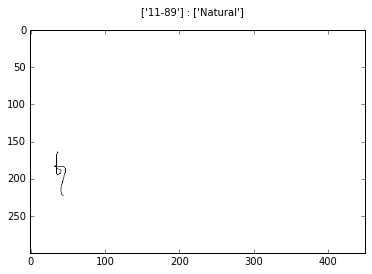

In [52]:
plot_image('11-89', allcoords, xdims, interpolate = True)

In [26]:
!cat ../../HOMUS/1/1-1.txt

12-8-Time
13,120;13,120;14,122;15,126;16,132;16,137;18,140;19,140;21,140;21,140;
29,124;31,124;35,126;36,127;35,130;34,134;34,137;36,139;41,140;41,139;41,139;
28,170;30,171;36,179;39,184;39,189;39,191;35,191;32,188;30,184;30,179;35,170;38,165;37,162;33,163;26,166;19,171;18,174;18,174;

In [34]:
import sys

In [35]:
sys.version

'3.4.3 (default, Jun 28 2015, 20:06:24) \n[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'